Found 25417 CSV files

Category counts:
ewhc     14359
ewca      8396
ukftt      848
ewfc       459
ukut       424
ewcop      374
eat        269
uksc       176
ukpc        71
ukait       29
ewcc         1
Name: count, dtype: int64


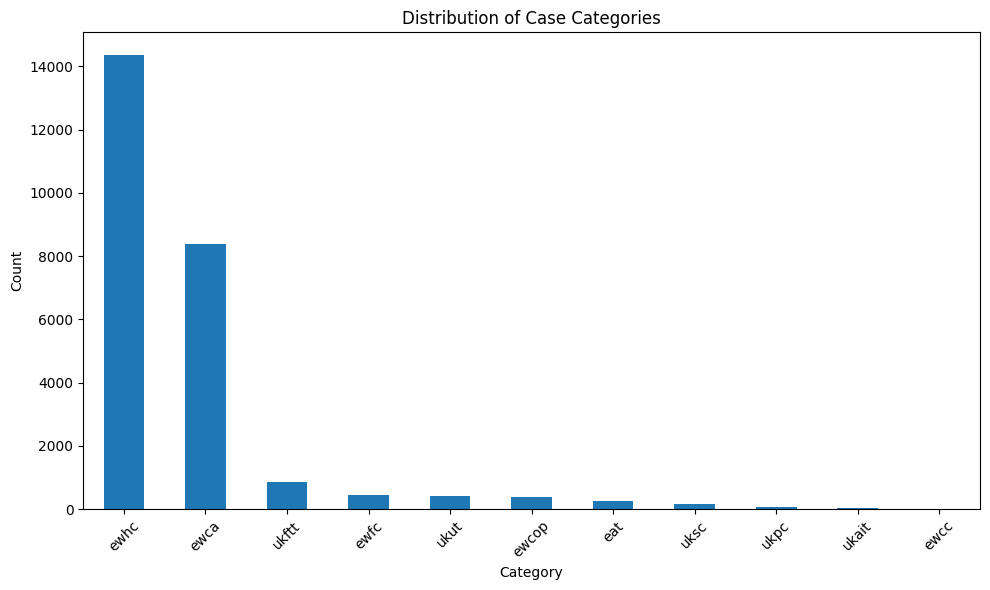


Example case_uri values:
ewhc: https://caselaw.nationalarchives.gov.uk/ewhc/fam/2013/235
ewca: https://caselaw.nationalarchives.gov.uk/ewca/crim/2013/1397
ewhc: https://caselaw.nationalarchives.gov.uk/ewhc/admin/2013/301
ewhc: https://caselaw.nationalarchives.gov.uk/ewhc/fam/2013/292
ewca: https://caselaw.nationalarchives.gov.uk/ewca/crim/2013/2536


In [25]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import os

# Read all CSV files in the folder
parent_folder = '/Users/apple/Documents/Swansea/Projects/Caselaw having legislation reference and proper paragraph numbering'

# Get all CSV files recursively
csv_files = []
for root, dirs, files in os.walk(parent_folder):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print(f"Found {len(csv_files)} CSV files")

# Initialize list to store categories and file mappings
categories = []
file_category_mapping = {}  # To track which file belongs to which category

# Read case_uri from each CSV and extract category
for file in csv_files:
    try:
        # Read CSV with error handling
        df = pd.read_csv(file, encoding='utf-8', on_bad_lines='skip')
        
        if 'case_uri' in df.columns and len(df) > 0:
            # Get the first non-null case_uri
            case_uri_series = df['case_uri'].dropna()
            if len(case_uri_series) > 0:
                url = case_uri_series.iloc[0]
                
                # Parse URL to get category
                parsed_url = urlparse(url)
                path_parts = [part for part in parsed_url.path.split('/') if part]  # Remove empty parts
                
                if len(path_parts) > 0:
                    category = path_parts[0]  # First part after domain
                    categories.append(category)
                    file_category_mapping[file] = category
                else:
                    print(f"Warning: Could not extract category from URL in {file}")
            else:
                print(f"Warning: No valid case_uri found in {file}")
        else:
            print(f"Warning: No 'case_uri' column or empty file: {file}")
            
    except Exception as e:
        print(f"Error reading {file}: {str(e)}")
        continue

# Count categories
if categories:
    category_counts = pd.Series(categories).value_counts()
    print("\nCategory counts:")
    print(category_counts)
    
    # Optional: Plot the distribution
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='bar')
    plt.title('Distribution of Case Categories')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No categories found. Check your CSV files and case_uri format.")

# Print some example URLs for debugging
print("\nExample case_uri values:")
for i, (file, category) in enumerate(list(file_category_mapping.items())[:5]):
    try:
        df = pd.read_csv(file, encoding='utf-8', on_bad_lines='skip')
        if 'case_uri' in df.columns and len(df) > 0:
            url = df['case_uri'].dropna().iloc[0]
            print(f"{category}: {url}")
    except:
        pass

In [30]:
import pandas as pd
import numpy as np
import os
import shutil
from urllib.parse import urlparse
from collections import defaultdict
import math

def stratified_sample_caselaws(parent_folder, total_sample_size=400, output_folder=None):
    """
    Create a stratified sample of case law files based on category distribution.
    
    Args:
        parent_folder: Path to folder containing CSV files
        total_sample_size: Total number of files to sample (default: 400)
        output_folder: Where to copy sampled files (optional)
    
    Returns:
        Dictionary with sampling results or None if failed
    """
    
    # Step 1: Get all CSV files and their categories
    print("Step 1: Scanning CSV files and extracting categories...")
    
    csv_files = []
    for root, dirs, files in os.walk(parent_folder):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    
    print(f"Found {len(csv_files)} CSV files")
    
    # Step 2: Extract categories and build file mapping
    print("Step 2: Extracting categories from case_uri...")
    
    file_category_mapping = {}
    category_files = defaultdict(list)
    
    for file in csv_files:
        try:
            df = pd.read_csv(file, encoding='utf-8', on_bad_lines='skip')
            
            if 'case_uri' in df.columns and len(df) > 0:
                case_uri_series = df['case_uri'].dropna()
                if len(case_uri_series) > 0:
                    url = str(case_uri_series.iloc[0])  # Convert to string
                    
                    # Handle different URL formats
                    if url.startswith('http'):
                        parsed_url = urlparse(url)
                        path_parts = [part for part in parsed_url.path.split('/') if part]
                    else:
                        # Handle URLs that might not have http:// prefix
                        # or are just paths like /ewhc/admin/2025/462
                        path_parts = [part for part in url.split('/') if part]
                    
                    if len(path_parts) > 0:
                        category = path_parts[0]
                        file_category_mapping[file] = category
                        category_files[category].append(file)
                    else:
                        print(f"Warning: Could not extract category from URL '{url}' in {file}")
                else:
                    print(f"Warning: No valid case_uri found in {file}")
            else:
                print(f"Warning: No 'case_uri' column or empty file: {file}")
                
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
            continue
    
    # Step 3: Calculate category distribution
    print("Step 3: Calculating category distribution...")
    
    # Check if any categories were found
    if not category_files:
        print("ERROR: No categories found!")
        print("Possible issues:")
        print("1. No CSV files contain 'case_uri' column")
        print("2. All case_uri values are empty/null")
        print("3. URL format doesn't match expected pattern")
        print("\nDebugging: Let's check a few files...")
        
        # Debug: Check first few CSV files
        for i, file in enumerate(csv_files[:5]):
            try:
                df = pd.read_csv(file, encoding='utf-8', on_bad_lines='skip')
                print(f"\nFile {i+1}: {os.path.basename(file)}")
                print(f"  Columns: {list(df.columns)}")
                if 'case_uri' in df.columns:
                    sample_uris = df['case_uri'].dropna().head(3)
                    print(f"  Sample case_uri values: {list(sample_uris)}")
                else:
                    print(f"  No 'case_uri' column found")
            except Exception as e:
                print(f"  Error reading file: {e}")
        
        return None
    
    category_counts = {}
    for category, files in category_files.items():
        category_counts[category] = len(files)
    
    total_files = sum(category_counts.values())
    print(f"\nTotal categorized files: {total_files}")
    
    if total_files == 0:
        print("ERROR: No files were successfully categorized!")
        return None
    
    print(f"Category distribution:")
    
    category_proportions = {}
    for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
        proportion = count / total_files
        category_proportions[category] = proportion
        print(f"  {category}: {count} files ({proportion:.2%})")
    
    # Step 4: Calculate stratified sample sizes
    print(f"\nStep 4: Calculating stratified sample for {total_sample_size} files...")
    
    sample_sizes = {}
    allocated_total = 0
    
    # First pass: Ensure minimum 5 files per category (if available)
    for category, proportion in category_proportions.items():
        available_files = len(category_files[category])
        
        if available_files >= 5:
            min_sample = 5  # At least 5 if category has 5+ files
        else:
            min_sample = min(1, available_files)  # At least 1 if less than 5 files
        
        # Calculate proportional sample size
        ideal_sample = proportion * total_sample_size
        
        # Use the larger of minimum required or proportional allocation
        sample_size = min(max(round(ideal_sample), min_sample), available_files)
        
        sample_sizes[category] = sample_size
        allocated_total += sample_size
    
    # Adjust for rounding differences and minimum requirements
    difference = total_sample_size - allocated_total
    
    print(f"Initial allocation: {allocated_total} files")
    if allocated_total > total_sample_size:
        print(f"Note: Minimum requirements exceeded target by {allocated_total - total_sample_size} files")
        print(f"Adjusting target to {allocated_total} to maintain minimum 5 files per category")
        total_sample_size = allocated_total  # Adjust target upward
        difference = 0
    
    if difference != 0:  # Only adjust if there's a difference
        # Sort categories by largest remainder to adjust
        remainders = []
        for category in category_proportions:
            ideal_sample = category_proportions[category] * total_sample_size
            remainder = ideal_sample - sample_sizes[category]
            remainders.append((remainder, category))
        
        remainders.sort(reverse=True)
        
        # Adjust sample sizes (only if we have categories)
        if len(remainders) > 0:
            for i in range(abs(difference)):
                if difference > 0:  # Need to add more
                    category = remainders[i % len(remainders)][1]
                    if sample_sizes[category] < len(category_files[category]):
                        sample_sizes[category] += 1
                else:  # Need to remove some
                    category = remainders[-(i % len(remainders)) - 1][1]
                    # Don't reduce below minimum of 5 (or available files if less than 5)
                    available_files = len(category_files[category])
                    min_required = 5 if available_files >= 5 else available_files
                    if sample_sizes[category] > min_required:
                        sample_sizes[category] -= 1
    
    print(f"\nStratified sample allocation:")
    total_allocated = sum(sample_sizes.values())
    for category, size in sorted(sample_sizes.items(), key=lambda x: x[1], reverse=True):
        available = len(category_files[category])
        percentage = (size / total_allocated) * 100
        min_note = " (min 5)" if available >= 5 and size == 5 else ""
        print(f"  {category}: {size} files ({percentage:.1f}%) [Available: {available}]{min_note}")
    
    print(f"\nFinal total allocated: {total_allocated}")
    if total_allocated != total_sample_size:
        print(f"Note: Total adjusted from {total_sample_size} to {total_allocated} to meet minimum requirements")
    
    # Step 5: Perform stratified sampling
    print("\nStep 5: Performing stratified sampling...")
    
    sampled_files = {}
    all_sampled_files = []
    
    np.random.seed(42)  # For reproducible results
    
    for category, sample_size in sample_sizes.items():
        available_files = category_files[category]
        if sample_size <= len(available_files):
            # Random sample without replacement
            sampled = np.random.choice(available_files, size=sample_size, replace=False)
            sampled_files[category] = list(sampled)
            all_sampled_files.extend(sampled)
        else:
            # Take all available files if sample size exceeds available
            sampled_files[category] = available_files
            all_sampled_files.extend(available_files)
    
    print(f"Successfully sampled {len(all_sampled_files)} files")
    
    # Step 6: Copy files to output folder (optional)
    if output_folder:
        print(f"\nStep 6: Copying sampled files to {output_folder}...")
        
        # Create output directory structure
        os.makedirs(output_folder, exist_ok=True)
        
        for category, files in sampled_files.items():
            category_dir = os.path.join(output_folder, category)
            os.makedirs(category_dir, exist_ok=True)
            
            for file_path in files:
                filename = os.path.basename(file_path)
                dest_path = os.path.join(category_dir, filename)
                shutil.copy2(file_path, dest_path)
        
        print(f"Files copied to {output_folder}")
    
    # Step 7: Create summary report
    summary = {
        'total_files_found': len(csv_files),
        'total_categorized': total_files,
        'total_sampled': len(all_sampled_files),
        'category_distribution': category_counts,
        'sample_sizes': sample_sizes,
        'sampled_files': sampled_files,
        'all_sampled_files': all_sampled_files
    }
    
    return summary

def save_sample_manifest(summary, output_file='sample_manifest.txt'):
    """Save a detailed manifest of the sampling results."""
    
    with open(output_file, 'w') as f:
        f.write("STRATIFIED CASE LAW SAMPLING REPORT\n")
        f.write("=" * 50 + "\n\n")
        
        f.write(f"Total files found: {summary['total_files_found']}\n")
        f.write(f"Total categorized: {summary['total_categorized']}\n")
        f.write(f"Total sampled: {summary['total_sampled']}\n\n")
        
        f.write("CATEGORY DISTRIBUTION:\n")
        f.write("-" * 30 + "\n")
        for category, count in sorted(summary['category_distribution'].items(), 
                                    key=lambda x: x[1], reverse=True):
            sample_size = summary['sample_sizes'][category]
            percentage = (sample_size / summary['total_sampled']) * 100
            f.write(f"{category}: {count} total → {sample_size} sampled ({percentage:.1f}%)\n")
        
        f.write(f"\nSAMPLED FILES BY CATEGORY:\n")
        f.write("-" * 30 + "\n")
        for category, files in summary['sampled_files'].items():
            f.write(f"\n{category} ({len(files)} files):\n")
            for file_path in files:
                f.write(f"  {os.path.basename(file_path)}\n")
    
    print(f"Sample manifest saved to {output_file}")

def diagnose_csv_files(parent_folder, max_files_to_check=10):
    """
    Diagnose CSV files to understand their structure and content.
    """
    print("CSV FILE DIAGNOSTIC TOOL")
    print("=" * 50)
    
    # Get all CSV files
    csv_files = []
    for root, dirs, files in os.walk(parent_folder):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    
    print(f"Found {len(csv_files)} CSV files")
    print(f"Checking first {min(max_files_to_check, len(csv_files))} files...\n")
    
    files_with_case_uri = 0
    sample_case_uris = []
    column_summary = {}
    
    for i, file in enumerate(csv_files[:max_files_to_check]):
        print(f"File {i+1}: {os.path.basename(file)}")
        print(f"  Path: {file}")
        
        try:
            # Try to read the file
            df = pd.read_csv(file, encoding='utf-8', on_bad_lines='skip')
            print(f"  Shape: {df.shape}")
            print(f"  Columns: {list(df.columns)}")
            
            # Track columns across files
            for col in df.columns:
                column_summary[col] = column_summary.get(col, 0) + 1
            
            # Check for case_uri column
            if 'case_uri' in df.columns:
                files_with_case_uri += 1
                print(f"  ✓ Has 'case_uri' column")
                
                # Get sample case_uri values
                case_uris = df['case_uri'].dropna()
                if len(case_uris) > 0:
                    sample_uri = str(case_uris.iloc[0])
                    print(f"  Sample case_uri: '{sample_uri}'")
                    sample_case_uris.append(sample_uri)
                    
                    # Try to extract category
                    try:
                        if sample_uri.startswith('http'):
                            parsed_url = urlparse(sample_uri)
                            path_parts = [part for part in parsed_url.path.split('/') if part]
                        else:
                            path_parts = [part for part in sample_uri.split('/') if part]
                        
                        if len(path_parts) > 0:
                            category = path_parts[0]
                            print(f"  Extracted category: '{category}'")
                        else:
                            print(f"  ⚠️  Could not extract category from path")
                    except Exception as e:
                        print(f"  ⚠️  Error parsing URL: {e}")
                else:
                    print(f"  ⚠️  case_uri column is empty")
            else:
                print(f"  ❌ No 'case_uri' column")
                
        except Exception as e:
            print(f"  ❌ Error reading file: {e}")
        
        print()  # Empty line for readability
    
    # Summary
    print("DIAGNOSTIC SUMMARY")
    print("=" * 30)
    print(f"Files checked: {min(max_files_to_check, len(csv_files))}")
    print(f"Files with 'case_uri': {files_with_case_uri}")
    
    print(f"\nColumn frequency across files:")
    for col, count in sorted(column_summary.items(), key=lambda x: x[1], reverse=True):
        print(f"  {col}: {count} files")
    
    if sample_case_uris:
        print(f"\nSample case_uri formats:")
        unique_formats = list(set(sample_case_uris[:5]))  # Show up to 5 unique formats
        for uri in unique_formats:
            print(f"  {uri}")
            
        # Try to identify common patterns
        print(f"\nURL pattern analysis:")
        http_count = sum(1 for uri in sample_case_uris if uri.startswith('http'))
        path_only_count = sum(1 for uri in sample_case_uris if uri.startswith('/'))
        other_count = len(sample_case_uris) - http_count - path_only_count
        
        print(f"  Full URLs (http/https): {http_count}")
        print(f"  Path only (starts with /): {path_only_count}")
        print(f"  Other format: {other_count}")
    else:
        print(f"\n❌ No valid case_uri values found!")
        print("This is why the stratified sampling failed.")
        
    # Recommendations
    print(f"\nRECOMMENDATIONS:")
    if files_with_case_uri == 0:
        print("❌ No files contain 'case_uri' column")
        print("   → Check if the column has a different name")
        print("   → Verify you're looking in the correct directory")
    elif len(sample_case_uris) == 0:
        print("❌ Files have 'case_uri' column but no valid values")
        print("   → Check for missing/null values")
        print("   → Verify data integrity")
    else:
        print("✓ Found valid case_uri values")
        print("   → The stratified sampling should work")
        print("   → If it's still failing, try running with fewer files first")

# Main execution
if __name__ == "__main__":
    # Configuration
    parent_folder = '/Users/apple/Documents/Swansea/Projects/Caselaw having legislation reference and proper paragraph numbering'
    output_folder = '/Users/apple/Documents/Swansea/Projects/Sampled_Caselaws_400'  # Change this path
    sample_size = 400
    
    # First run diagnostic (uncomment to use)
    # print("RUNNING DIAGNOSTIC FIRST...")
    # diagnose_csv_files(parent_folder, max_files_to_check=20)
    # print("\n" + "="*50 + "\n")
    
    # Perform stratified sampling
    print("STRATIFIED CASE LAW SAMPLING")
    print("=" * 50)
    
    results = stratified_sample_caselaws(
        parent_folder=parent_folder,
        total_sample_size=sample_size,
        output_folder=output_folder
    )
    
    # Check if sampling was successful
    if results is None:
        print("\nSampling failed! Please check the debug information above.")
        print("Common solutions:")
        print("1. Check if CSV files have 'case_uri' column")
        print("2. Verify case_uri format (should contain category in path)")
        print("3. Ensure files are not corrupted")
        print("\nTry running the diagnostic script first to identify the issue.")
    else:
        # Save manifest
        save_sample_manifest(results, 'stratified_sample_manifest.txt')
        
        print("\n" + "=" * 50)
        print("SAMPLING COMPLETE!")
        print(f"Sampled {results['total_sampled']} files from {results['total_categorized']} categorized files")
        print(f"Files copied to: {output_folder}")
        print("Check 'stratified_sample_manifest.txt' for detailed report")

STRATIFIED CASE LAW SAMPLING
Step 1: Scanning CSV files and extracting categories...
Found 25417 CSV files
Step 2: Extracting categories from case_uri...
Step 3: Calculating category distribution...

Total categorized files: 25406
Category distribution:
  ewhc: 14359 files (56.52%)
  ewca: 8396 files (33.05%)
  ukftt: 848 files (3.34%)
  ewfc: 459 files (1.81%)
  ukut: 424 files (1.67%)
  ewcop: 374 files (1.47%)
  eat: 269 files (1.06%)
  uksc: 176 files (0.69%)
  ukpc: 71 files (0.28%)
  ukait: 29 files (0.11%)
  ewcc: 1 files (0.00%)

Step 4: Calculating stratified sample for 400 files...
Initial allocation: 412 files
Note: Minimum requirements exceeded target by 12 files
Adjusting target to 412 to maintain minimum 5 files per category

Stratified sample allocation:
  ewhc: 226 files (54.9%) [Available: 14359]
  ewca: 132 files (32.0%) [Available: 8396]
  ukftt: 13 files (3.2%) [Available: 848]
  ewfc: 7 files (1.7%) [Available: 459]
  ukut: 7 files (1.7%) [Available: 424]
  ewcop: 

In [31]:
import pandas as pd
import os
import csv
from urllib.parse import urlparse
import re

def update_para_id(file_name, para_id):
    """Update para_id by combining filename and original para_id"""
    return f"{file_name}#{para_id}"

def extract_case_info_from_filename(filename):
    """
    Extract category, year, and case number from filename
    Expected format: category_year_number.csv
    """
    # Remove .csv extension
    name_without_ext = os.path.splitext(filename)[0]
    
    # Try to parse category_year_number format
    parts = name_without_ext.split('_')
    if len(parts) >= 3:
        category = parts[0]
        year = parts[1]
        number = '_'.join(parts[2:])  # In case number contains underscores
        return category, year, number
    else:
        # Fallback: use the whole filename
        return name_without_ext, '', ''

def clean_text_columns(df):
    """Clean text columns by removing newlines, tabs, and extra whitespace"""
    df_clean = df.copy()
    
    # Clean all object (string) columns
    for col in df_clean.select_dtypes(include=['object']).columns:
        df_clean[col] = (df_clean[col]
                        .astype(str)
                        .str.replace('\n', ' ', regex=False)
                        .str.replace('\r', ' ', regex=False)
                        .str.replace('\t', ' ', regex=False)
                        .str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with single space
                        .str.strip())  # Remove leading/trailing whitespace
    
    return df_clean

def combine_sampled_csvs(sampled_folder, output_file, max_files=None):
    """
    Combine all CSV files from the sampled folder into one master CSV.
    
    Args:
        sampled_folder: Path to folder containing sampled CSV files
        output_file: Path for the combined output CSV
        max_files: Optional limit on number of files to process (for testing)
    """
    
    print("COMBINING SAMPLED CSV FILES")
    print("=" * 50)
    
    # Get all CSV files recursively
    csv_files = []
    for root, dirs, files in os.walk(sampled_folder):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    
    if max_files:
        csv_files = csv_files[:max_files]
        print(f"Processing first {max_files} files for testing...")
    
    print(f"Found {len(csv_files)} CSV files to combine")
    
    # Track statistics
    combined_data = []
    file_stats = {}
    total_rows = 0
    files_processed = 0
    files_with_errors = 0
    
    for i, csv_path in enumerate(csv_files):
        try:
            # Get filename without extension for para_id update
            file_name = os.path.splitext(os.path.basename(csv_path))[0]
            category, year, number = extract_case_info_from_filename(os.path.basename(csv_path))
            
            print(f"Processing {i+1}/{len(csv_files)}: {file_name}")
            
            # Read CSV file
            df = pd.read_csv(csv_path, encoding='utf-8', on_bad_lines='skip')
            
            if len(df) == 0:
                print(f"  Warning: Empty file, skipping")
                continue
            
            # Update para_id column if it exists
            if 'para_id' in df.columns:
                df['para_id'] = df['para_id'].apply(lambda x: update_para_id(file_name, str(x)))
            else:
                # Create para_id if it doesn't exist
                df['para_id'] = [f"{file_name}#{idx}" for idx in range(len(df))]
                print(f"  Info: Created para_id column")
            
            # Add metadata columns
            df['source_file'] = file_name
            df['source_category'] = category
            df['source_year'] = year
            df['source_case_number'] = number
            df['source_full_path'] = csv_path
            
            # Clean text columns
            df_clean = clean_text_columns(df)
            
            # Add to combined data
            combined_data.append(df_clean)
            
            # Track statistics
            file_stats[file_name] = {
                'rows': len(df_clean),
                'columns': len(df_clean.columns),
                'category': category,
                'year': year
            }
            
            total_rows += len(df_clean)
            files_processed += 1
            
            # Progress update
            if (i + 1) % 50 == 0:
                print(f"  Progress: {i+1}/{len(csv_files)} files processed, {total_rows} total rows")
                
        except Exception as e:
            print(f"  Error processing {csv_path}: {str(e)}")
            files_with_errors += 1
            continue
    
    if not combined_data:
        print("ERROR: No data was successfully processed!")
        return None
    
    print(f"\nCombining data from {files_processed} files...")
    
    # Combine all dataframes
    combined_df = pd.concat(combined_data, ignore_index=True, sort=False)
    
    print(f"Combined dataset shape: {combined_df.shape}")
    print(f"Total rows: {len(combined_df)}")
    print(f"Total columns: {len(combined_df.columns)}")
    
    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Save to CSV with proper quoting
    print(f"\nSaving to: {output_file}")
    combined_df.to_csv(output_file, 
                      index=False, 
                      quoting=csv.QUOTE_ALL,
                      encoding='utf-8')
    
    # Generate summary report
    print(f"\nSUMMARY REPORT")
    print("=" * 30)
    print(f"Files processed successfully: {files_processed}")
    print(f"Files with errors: {files_with_errors}")
    print(f"Total rows in combined dataset: {len(combined_df)}")
    print(f"Total columns: {len(combined_df.columns)}")
    
    # Column summary
    print(f"\nColumn names in combined dataset:")
    for i, col in enumerate(combined_df.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Category breakdown
    if 'source_category' in combined_df.columns:
        print(f"\nRows by category:")
        category_counts = combined_df['source_category'].value_counts()
        for category, count in category_counts.items():
            percentage = (count / len(combined_df)) * 100
            print(f"  {category}: {count} rows ({percentage:.1f}%)")
    
    # Year breakdown
    if 'source_year' in combined_df.columns:
        print(f"\nRows by year:")
        year_counts = combined_df['source_year'].value_counts().sort_index()
        for year, count in year_counts.items():
            print(f"  {year}: {count} rows")
    
    # Sample of para_id format
    if 'para_id' in combined_df.columns:
        print(f"\nSample para_id formats:")
        sample_para_ids = combined_df['para_id'].head(5).tolist()
        for para_id in sample_para_ids:
            print(f"  {para_id}")
    
    # Save detailed file statistics
    stats_file = output_file.replace('.csv', '_file_stats.csv')
    stats_df = pd.DataFrame.from_dict(file_stats, orient='index')
    stats_df.to_csv(stats_file)
    print(f"\nDetailed file statistics saved to: {stats_file}")
    
    return {
        'combined_df': combined_df,
        'files_processed': files_processed,
        'files_with_errors': files_with_errors,
        'file_stats': file_stats,
        'output_file': output_file
    }

def test_sample_combination(sampled_folder, output_file):
    """Test the combination process with a small sample first"""
    print("TESTING WITH SAMPLE FILES")
    print("=" * 30)
    
    result = combine_sampled_csvs(sampled_folder, 
                                 output_file.replace('.csv', '_test.csv'), 
                                 max_files=10)
    
    if result:
        print("✓ Test successful! Ready to process all files.")
        return True
    else:
        print("✗ Test failed. Check the errors above.")
        return False

# Main execution
if __name__ == "__main__":
    # Configuration
    sampled_folder = '/Users/apple/Documents/Swansea/Projects/Sampled_Caselaws_400'
    output_file = '/Users/apple/Documents/Swansea/Projects/combined_sampled_caselaws.csv'
    
    # Option 1: Test with small sample first (recommended)
    print("OPTION 1: Testing with sample files first...")
    test_success = test_sample_combination(sampled_folder, output_file)
    
    if test_success:
        print(f"\n" + "="*50)
        print("PROCEEDING WITH FULL COMBINATION...")
        
        # Option 2: Process all files
        result = combine_sampled_csvs(sampled_folder, output_file)
        
        if result:
            print(f"\n" + "="*50)
            print("COMBINATION COMPLETE!")
            print(f"Combined dataset saved to: {output_file}")
            print(f"Processed {result['files_processed']} files successfully")
            print(f"Total rows in combined dataset: {len(result['combined_df'])}")
        else:
            print("Combination failed!")
    else:
        print("Fix the issues identified in the test before proceeding.")

OPTION 1: Testing with sample files first...
TESTING WITH SAMPLE FILES
COMBINING SAMPLED CSV FILES
Processing first 10 files for testing...
Found 10 CSV files to combine
Processing 1/10: HM Revenue & Customs v Banerjee
Processing 2/10: Edward Thomas & Ors v Metro Bank Plc & Ors
Processing 3/10: Andromeda Marine SA v OW Bunker & Trading A_S
Processing 4/10: A Local Authority v PD & Ors
Processing 5/10: Ferko v Ealing Magistrates Court & Ors
Processing 6/10: Marine Oil Traders v Vitol SA & Anor
Processing 7/10: A & Anor v Northamptonshire County Counci & Ors
Processing 8/10: A, R (On the Application Of) v Secretary Of State For The Home Department
Processing 9/10: Save Britain's Heritage, R (on the application of) v Westminster City Council & Anor
Processing 10/10: S v Crown Prosecution Service

Combining data from 10 files...
Combined dataset shape: (384, 9)
Total rows: 384
Total columns: 9

Saving to: /Users/apple/Documents/Swansea/Projects/combined_sampled_caselaws_test.csv

SUMMARY R

In [32]:
import pandas as pd
import os
import csv
from urllib.parse import urlparse
import re

def extract_case_id_from_uri(case_uri):
    """
    Extract case ID from case_uri URL.
    
    From: https://caselaw.nationalarchives.gov.uk/ewhc/ch/2009/1229
    To: ewhc_ch_2009_1229
    """
    try:
        if pd.isna(case_uri) or str(case_uri).lower() in ['nan', 'none', '']:
            return None
            
        case_uri = str(case_uri)
        
        # Parse URL to get path
        if case_uri.startswith('http'):
            parsed_url = urlparse(case_uri)
            path = parsed_url.path
        else:
            # Handle cases where it might just be a path
            path = case_uri
        
        # Remove leading/trailing slashes and split
        path_parts = [part for part in path.split('/') if part]
        
        # Expected format: ['ewhc', 'ch', '2009', '1229']
        if len(path_parts) >= 2:
            case_id = '_'.join(path_parts)
            return case_id
        else:
            return None
            
    except Exception as e:
        print(f"  Warning: Could not parse case_uri '{case_uri}': {e}")
        return None

def update_para_id_from_uri(case_uri, para_id):
    """
    Update para_id using case_uri instead of filename.
    
    Args:
        case_uri: URL like https://caselaw.nationalarchives.gov.uk/ewhc/ch/2009/1229
        para_id: Original para_id like para_27
    
    Returns:
        Updated para_id like ewhc_ch_2009_1229#para_27
    """
    case_id = extract_case_id_from_uri(case_uri)
    
    if case_id:
        return f"{case_id}#{para_id}"
    else:
        # Fallback to original para_id if URI parsing fails
        return str(para_id)

def update_para_id(file_name, para_id):
    """Update para_id by combining filename and original para_id (fallback method)"""
    return f"{file_name}#{para_id}"

def extract_case_info_from_filename(filename):
    """
    Extract category, year, and case number from filename
    Expected format: category_year_number.csv
    """
    # Remove .csv extension
    name_without_ext = os.path.splitext(filename)[0]
    
    # Try to parse category_year_number format
    parts = name_without_ext.split('_')
    if len(parts) >= 3:
        category = parts[0]
        year = parts[1]
        number = '_'.join(parts[2:])  # In case number contains underscores
        return category, year, number
    else:
        # Fallback: use the whole filename
        return name_without_ext, '', ''

def clean_text_columns(df):
    """Clean text columns by removing newlines, tabs, and extra whitespace"""
    df_clean = df.copy()
    
    # Clean all object (string) columns
    for col in df_clean.select_dtypes(include=['object']).columns:
        df_clean[col] = (df_clean[col]
                        .astype(str)
                        .str.replace('\n', ' ', regex=False)
                        .str.replace('\r', ' ', regex=False)
                        .str.replace('\t', ' ', regex=False)
                        .str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with single space
                        .str.strip())  # Remove leading/trailing whitespace
    
    return df_clean

def combine_sampled_csvs(sampled_folder, output_file, max_files=None):
    """
    Combine all CSV files from the sampled folder into one master CSV.
    
    Args:
        sampled_folder: Path to folder containing sampled CSV files
        output_file: Path for the combined output CSV
        max_files: Optional limit on number of files to process (for testing)
    """
    
    print("COMBINING SAMPLED CSV FILES")
    print("=" * 50)
    
    # Get all CSV files recursively
    csv_files = []
    for root, dirs, files in os.walk(sampled_folder):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    
    if max_files:
        csv_files = csv_files[:max_files]
        print(f"Processing first {max_files} files for testing...")
    
    print(f"Found {len(csv_files)} CSV files to combine")
    
    # Track statistics
    combined_data = []
    file_stats = {}
    total_rows = 0
    files_processed = 0
    files_with_errors = 0
    
    for i, csv_path in enumerate(csv_files):
        try:
            # Get filename without extension for para_id update
            file_name = os.path.splitext(os.path.basename(csv_path))[0]
            category, year, number = extract_case_info_from_filename(os.path.basename(csv_path))
            
            print(f"Processing {i+1}/{len(csv_files)}: {file_name}")
            
            # Read CSV file
            df = pd.read_csv(csv_path, encoding='utf-8', on_bad_lines='skip')
            
            if len(df) == 0:
                print(f"  Warning: Empty file, skipping")
                continue
            
            # Update para_id column using case_uri if available
            if 'para_id' in df.columns:
                if 'case_uri' in df.columns:
                    # Method 1: Use case_uri to generate proper para_id
                    print(f"  Info: Updating para_id using case_uri")
                    df['para_id'] = df.apply(lambda row: update_para_id_from_uri(row['case_uri'], row['para_id']), axis=1)
                else:
                    # Method 2: Fallback to filename-based para_id
                    print(f"  Info: No case_uri found, using filename for para_id")
                    df['para_id'] = df['para_id'].apply(lambda x: update_para_id(file_name, str(x)))
            else:
                # Create para_id if it doesn't exist
                if 'case_uri' in df.columns:
                    print(f"  Info: Creating para_id using case_uri")
                    df['para_id'] = df.apply(lambda row: update_para_id_from_uri(row['case_uri'], f"para_{row.name}"), axis=1)
                else:
                    print(f"  Info: Creating para_id using filename")
                    df['para_id'] = [f"{file_name}#{idx}" for idx in range(len(df))]
            
            # Add metadata columns
            df['source_file'] = file_name
            df['source_category'] = category
            df['source_year'] = year
            df['source_case_number'] = number
            df['source_full_path'] = csv_path
            
            # Clean text columns
            df_clean = clean_text_columns(df)
            
            # Add to combined data
            combined_data.append(df_clean)
            
            # Track statistics
            file_stats[file_name] = {
                'rows': len(df_clean),
                'columns': len(df_clean.columns),
                'category': category,
                'year': year
            }
            
            total_rows += len(df_clean)
            files_processed += 1
            
            # Progress update
            if (i + 1) % 50 == 0:
                print(f"  Progress: {i+1}/{len(csv_files)} files processed, {total_rows} total rows")
                
        except Exception as e:
            print(f"  Error processing {csv_path}: {str(e)}")
            files_with_errors += 1
            continue
    
    if not combined_data:
        print("ERROR: No data was successfully processed!")
        return None
    
    print(f"\nCombining data from {files_processed} files...")
    
    # Combine all dataframes
    combined_df = pd.concat(combined_data, ignore_index=True, sort=False)
    
    print(f"Combined dataset shape: {combined_df.shape}")
    print(f"Total rows: {len(combined_df)}")
    print(f"Total columns: {len(combined_df.columns)}")
    
    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Save to CSV with proper quoting
    print(f"\nSaving to: {output_file}")
    combined_df.to_csv(output_file, 
                      index=False, 
                      quoting=csv.QUOTE_ALL,
                      encoding='utf-8')
    
    # Generate summary report
    print(f"\nSUMMARY REPORT")
    print("=" * 30)
    print(f"Files processed successfully: {files_processed}")
    print(f"Files with errors: {files_with_errors}")
    print(f"Total rows in combined dataset: {len(combined_df)}")
    print(f"Total columns: {len(combined_df.columns)}")
    
    # Column summary
    print(f"\nColumn names in combined dataset:")
    for i, col in enumerate(combined_df.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Category breakdown
    if 'source_category' in combined_df.columns:
        print(f"\nRows by category:")
        category_counts = combined_df['source_category'].value_counts()
        for category, count in category_counts.items():
            percentage = (count / len(combined_df)) * 100
            print(f"  {category}: {count} rows ({percentage:.1f}%)")
    
    # Year breakdown
    if 'source_year' in combined_df.columns:
        print(f"\nRows by year:")
        year_counts = combined_df['source_year'].value_counts().sort_index()
        for year, count in year_counts.items():
            print(f"  {year}: {count} rows")
    
    # Sample of para_id format
    if 'para_id' in combined_df.columns:
        print(f"\nSample para_id formats:")
        sample_para_ids = combined_df['para_id'].head(5).tolist()
        for para_id in sample_para_ids:
            print(f"  {para_id}")
    
    # Save detailed file statistics
    stats_file = output_file.replace('.csv', '_file_stats.csv')
    stats_df = pd.DataFrame.from_dict(file_stats, orient='index')
    stats_df.to_csv(stats_file)
    print(f"\nDetailed file statistics saved to: {stats_file}")
    
    return {
        'combined_df': combined_df,
        'files_processed': files_processed,
        'files_with_errors': files_with_errors,
        'file_stats': file_stats,
        'output_file': output_file
    }

def test_sample_combination(sampled_folder, output_file):
    """Test the combination process with a small sample first"""
    print("TESTING WITH SAMPLE FILES")
    print("=" * 30)
    
    result = combine_sampled_csvs(sampled_folder, 
                                 output_file.replace('.csv', '_test.csv'), 
                                 max_files=10)
    
    if result:
        print("✓ Test successful! Ready to process all files.")
        return True
    else:
        print("✗ Test failed. Check the errors above.")
        return False

# Main execution
if __name__ == "__main__":
    # Configuration
    sampled_folder = '/Users/apple/Documents/Swansea/Projects/Sampled_Caselaws_400'
    output_file = '/Users/apple/Documents/Swansea/Projects/combined_sampled_caselaws.csv'
    
    # Option 1: Test with small sample first (recommended)
    print("OPTION 1: Testing with sample files first...")
    test_success = test_sample_combination(sampled_folder, output_file)
    
    if test_success:
        print(f"\n" + "="*50)
        print("PROCEEDING WITH FULL COMBINATION...")
        
        # Option 2: Process all files
        result = combine_sampled_csvs(sampled_folder, output_file)
        
        if result:
            print(f"\n" + "="*50)
            print("COMBINATION COMPLETE!")
            print(f"Combined dataset saved to: {output_file}")
            print(f"Processed {result['files_processed']} files successfully")
            print(f"Total rows in combined dataset: {len(result['combined_df'])}")
        else:
            print("Combination failed!")
    else:
        print("Fix the issues identified in the test before proceeding.")

OPTION 1: Testing with sample files first...
TESTING WITH SAMPLE FILES
COMBINING SAMPLED CSV FILES
Processing first 10 files for testing...
Found 10 CSV files to combine
Processing 1/10: HM Revenue & Customs v Banerjee
  Info: Updating para_id using case_uri
Processing 2/10: Edward Thomas & Ors v Metro Bank Plc & Ors
  Info: Updating para_id using case_uri
Processing 3/10: Andromeda Marine SA v OW Bunker & Trading A_S
  Info: Updating para_id using case_uri
Processing 4/10: A Local Authority v PD & Ors
  Info: Updating para_id using case_uri
Processing 5/10: Ferko v Ealing Magistrates Court & Ors
  Info: Updating para_id using case_uri
Processing 6/10: Marine Oil Traders v Vitol SA & Anor
  Info: Updating para_id using case_uri
Processing 7/10: A & Anor v Northamptonshire County Counci & Ors
  Info: Updating para_id using case_uri
Processing 8/10: A, R (On the Application Of) v Secretary Of State For The Home Department
  Info: Updating para_id using case_uri
Processing 9/10: Save Brit

In [5]:
import pandas as pd
# Define file paths
output_file = '/Users/apple/Documents/Swansea/Projects/combined_sampled_caselaws.csv'
other_processed_files = '../data/test2/csvs_for_skip_phase_1/combined.csv'
final_output = '../data/final_test/combined_sampled_caselaws.csv'

# Read both dataframes
df1 = pd.read_csv(output_file)
df2 = pd.read_csv(other_processed_files)

# Select required columns
columns = ['case_uri', 'para_id', 'paragraphs', 'references']
df1 = df1[columns]
df2 = df2[columns]

# Combine dataframes and drop duplicates
combined_df = pd.concat([df1, df2], ignore_index=True)
combined_df = combined_df.drop_duplicates()

# Get number of unique URLs
unique_urls = combined_df['case_uri'].nunique()
print(f"Number of unique URLs: {unique_urls}")

# Save to final location
combined_df.to_csv(final_output, index=False)
print(f"Combined dataset saved to: {final_output}")


Number of unique URLs: 443
Combined dataset saved to: ../data/final_test/combined_sampled_caselaws.csv


In [6]:
len(combined_df)

24578

In [11]:


# Calculate proportional sampling
total_cases = 400
existing_cases = 15
remaining_cases = total_cases

# Calculate proportional distribution
proportions = category_counts / category_counts.sum()
target_counts = (proportions * remaining_cases).round().astype(int)

# Ensure each category has at least 1 case
for category in target_counts.index:
    if target_counts[category] < 1:
        target_counts[category] = 1

# Adjust remaining cases to maintain total
remaining = remaining_cases - target_counts.sum()
if remaining != 0:
    # Distribute remaining cases proportionally among categories
    while remaining != 0:
        if remaining > 0:
            target_counts[target_counts.idxmax()] += 1
            remaining -= 1
        else:
            target_counts[target_counts.idxmax()] -= 1
            remaining += 1

print("Target distribution of remaining cases:")
print(target_counts)

Target distribution of remaining cases:
ewhc     257
ewca     101
ukftt     11
ewfc      10
ewcop      5
ukut       5
eat        5
uksc       3
ukpc       1
ukait      1
ewcc       1
Name: count, dtype: int64


In [1]:
257-229

28

In [14]:
import shutil
import os

# Create folders and move files correctly
for category in target_counts.index:
    # Create category directory
    category_dir = os.path.join(parent_folder, category)
    os.makedirs(category_dir, exist_ok=True)
    
    # Move files to category directory
    for file in csv_files:
        if category in file:
            # Get just the filename without path
            filename = os.path.basename(file)
            # Construct proper destination path
            dest_path = os.path.join(category_dir, filename)
            # Move file
            shutil.move(file, dest_path)


In [18]:
target_counts

ewhc     257
ewca     101
ukftt     11
ewfc      10
ewcop      5
ukut       5
eat        5
uksc       3
ukpc       1
ukait      1
ewcc       1
Name: count, dtype: int64

In [19]:
# Combine all category CSV files into one
import pandas as pd
import glob

# Get all CSV files from category subdirectories
all_csv_files = []
total_files = 0
for category in target_counts.index:
    print(f"Processing {category}...")
    category_dir = os.path.join(parent_folder, category)
    category_files = glob.glob(os.path.join(category_dir, "*.csv"))
    all_csv_files.extend(category_files)
    total_files += len(category_files)
    print(f"Found {len(category_files)} files in {category}")

print(f"\nTotal files found: {total_files}")
print(f"Expected total based on target_counts: {target_counts.sum()}")

# Read and combine all CSV files
combined_df = pd.concat([pd.read_csv(f) for f in all_csv_files], ignore_index=True)

# Save combined file
output_path = os.path.join(parent_folder, "combined_categories.csv")
combined_df.to_csv(output_path, index=False)

print(f"\nCombined {len(all_csv_files)} CSV files into {output_path}")
print(f"Total rows in combined file: {len(combined_df)}")


Processing ewhc...
Found 0 files in ewhc
Processing ewca...
Found 38 files in ewca
Processing ukftt...
Found 0 files in ukftt
Processing ewfc...
Found 0 files in ewfc
Processing ewcop...
Found 0 files in ewcop
Processing ukut...
Found 0 files in ukut
Processing eat...
Found 186 files in eat
Processing uksc...
Found 0 files in uksc
Processing ukpc...
Found 0 files in ukpc
Processing ukait...
Found 1 files in ukait
Processing ewcc...
Found 0 files in ewcc

Total files found: 225
Expected total based on target_counts: 400

Combined 225 CSV files into /Users/apple/Documents/Swansea/Projects/Caselaw_having_legislation_reference_and_proper_paragraph_numbering/combined_categories.csv
Total rows in combined file: 15436


In [1]:
import pandas as pd
import math

# Data from your paper
court_data = {
    'Court Jurisdiction': [
        'EWHC (England and Wales High Court)',
        'EWCA (England and Wales Court of Appeal)', 
        'UKFTT (UK First-tier Tribunal)',
        'EWFC (England and Wales Family Court)',
        'UKUT (UK Upper Tribunal)',
        'EWCOP (England and Wales Court of Protection)',
        'UKSC (UK Supreme Court)',
        'EAT (Employment Appeal Tribunal)',
        'UKPC (UK Privy Council)',
        'UKAIT (UK Asylum and Immigration Tribunal)',
        'EWCC (England and Wales Crown Court)'
    ],
    'Original_Cases': [14359, 8396, 848, 459, 424, 374, 176, 269, 71, 29, 1]
}

# Parameters
n = 414  # Total sample size from finite population correction
N = 25406  # Total population size

# Create DataFrame
df = pd.DataFrame(court_data)
df['N_i'] = df['Original_Cases']  # Population size for stratum i

def calculate_sample_size(N_i, n, N):
    """
    Calculate sample size for stratum i using the formula:
    n_i = max(5, n * N_i/N) if N_i >= 5
    n_i = N_i if N_i < 5
    """
    if N_i >= 5:
        proportional_allocation = n * (N_i / N)
        return max(5, round(proportional_allocation))
    else:
        return N_i

# Apply the formula
df['Proportional_Allocation'] = df['N_i'].apply(lambda x: n * (x / N))
df['Sample_Size_ni'] = df['N_i'].apply(lambda x: calculate_sample_size(x, n, N))

# Calculate totals
total_original = df['N_i'].sum()
total_sample = df['Sample_Size_ni'].sum()

print("STRATIFIED SAMPLING ALLOCATION")
print("=" * 80)
print(f"Total Population (N): {total_original:,}")
print(f"Required Sample Size from Finite Correction (n): {n}")
print(f"Actual Total Sample Size: {total_sample}")
print(f"Difference: {total_sample - n} cases")
print("=" * 80)
print()

# Display results
print("DETAILED ALLOCATION BY COURT JURISDICTION:")
print("=" * 80)
for i, row in df.iterrows():
    court = row['Court Jurisdiction']
    N_i = row['N_i']
    prop_alloc = row['Proportional_Allocation']
    sample_size = row['Sample_Size_ni']
    percentage = (N_i / total_original) * 100
    
    print(f"{court}")
    print(f"  Population (N_i): {N_i:,} ({percentage:.1f}% of total)")
    print(f"  Proportional Allocation: {prop_alloc:.2f}")
    print(f"  Final Sample Size (n_i): {sample_size}")
    print(f"  Formula Used: {'max(5, n×N_i/N)' if N_i >= 5 else 'N_i'} (since N_i {'≥' if N_i >= 5 else '<'} 5)")
    print()

# Summary table
print("SUMMARY TABLE:")
print("=" * 80)
df_display = df[['Court Jurisdiction', 'N_i', 'Proportional_Allocation', 'Sample_Size_ni']].copy()
df_display.columns = ['Court Jurisdiction', 'Original Cases', 'Proportional Allocation', 'Final Sample Size']
df_display['Proportional Allocation'] = df_display['Proportional Allocation'].round(2)

# Add totals row
totals_row = pd.DataFrame({
    'Court Jurisdiction': ['TOTAL'],
    'Original Cases': [total_original],
    'Proportional Allocation': [n],
    'Final Sample Size': [total_sample]
})

df_summary = pd.concat([df_display, totals_row], ignore_index=True)
print(df_summary.to_string(index=False))

print("\n" + "=" * 80)
print("FORMULA VERIFICATION:")
print("=" * 80)
print("Formula: n_i = max(5, n × N_i/N) if N_i ≥ 5, n_i = N_i if N_i < 5")
print(f"Where: n = {n}, N = {N:,}")
print()

# Show calculations for a few examples
examples = [0, 1, 10]  # EWHC, EWCA, EWCC indices
for idx in examples:
    row = df.iloc[idx]
    court = row['Court Jurisdiction']
    N_i = row['N_i']
    calc = n * (N_i / N)
    result = row['Sample_Size_ni']
    
    print(f"Example - {court}:")
    print(f"  n_i = max(5, {n} × {N_i:,}/{N:,}) = max(5, {calc:.2f}) = {result}")
    print()

print("Note: The difference between required sample (414) and actual sample")
print(f"({total_sample}) is due to the minimum 5-case constraint for adequate")
print("representation across all court jurisdictions.")

STRATIFIED SAMPLING ALLOCATION
Total Population (N): 25,406
Required Sample Size from Finite Correction (n): 414
Actual Total Sample Size: 426
Difference: 12 cases

DETAILED ALLOCATION BY COURT JURISDICTION:
EWHC (England and Wales High Court)
  Population (N_i): 14,359 (56.5% of total)
  Proportional Allocation: 233.99
  Final Sample Size (n_i): 234
  Formula Used: max(5, n×N_i/N) (since N_i ≥ 5)

EWCA (England and Wales Court of Appeal)
  Population (N_i): 8,396 (33.0% of total)
  Proportional Allocation: 136.82
  Final Sample Size (n_i): 137
  Formula Used: max(5, n×N_i/N) (since N_i ≥ 5)

UKFTT (UK First-tier Tribunal)
  Population (N_i): 848 (3.3% of total)
  Proportional Allocation: 13.82
  Final Sample Size (n_i): 14
  Formula Used: max(5, n×N_i/N) (since N_i ≥ 5)

EWFC (England and Wales Family Court)
  Population (N_i): 459 (1.8% of total)
  Proportional Allocation: 7.48
  Final Sample Size (n_i): 7
  Formula Used: max(5, n×N_i/N) (since N_i ≥ 5)

UKUT (UK Upper Tribunal)
  Po